# Проект "Нупозвони"

## Этап 1. Знакомство с данными

Импортируем необходиме библиотеки.

In [102]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np 
import seaborn 
from scipy import stats as st
import matplotlib.pyplot as plt

Читаем файл, выводим первые строки.

In [103]:
data = pd.read_csv('telecom_dataset.csv') 
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


Каждая строка таблицы содержит информацию о количестве и общей продолжительности звонков одного типа у оператора за один день. Проверим данные на наличие дубликатов, пропусков и корректность типов данных.

## Этап 2. Подготовка данных

Рассмотрим данные поближе.

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Проверим на наличие дубликатов.

In [105]:
data.duplicated().sum()

4900

Удалим дубликаты.

In [106]:
data = data.drop_duplicates()

Посмотрим на пропуски в данных.

In [107]:
data.isna().sum()

user_id                   0
date                      0
direction                 0
internal                110
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

Рассчитаем долю пропусков в столбце internal в процентах.

In [108]:
round(data['internal'].isna().sum() / data.shape[0] * 100, 2)

0.22

Процент пропущенных значений маленький, поэтому можно удалить эти пропуски.

In [109]:
data = data.dropna(subset=['internal'])

Рассчитаем долю пропусков в столбце operator_id в процентах.

In [110]:
data['operator_id'].isna().sum() / data.shape[0] * 100

15.137445798903707

Процент пропущенных значений  по операторам уже довольно большой, однако замену мы найти не сможем, а так как все наше исследование напрямую связано с операторами, то придется удалить эти пропуски.

In [111]:
data = data.dropna(subset=['operator_id'])

Поменяем тип данных в столбцах с датой и внутренними/внешними вызовами.

In [112]:
data['date'] = pd.to_datetime(data['date']).dt.date

In [113]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [114]:
data = data.astype({'internal': 'bool', 'operator_id': 'object'})

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41491 entries, 1 to 53899
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41491 non-null  int64         
 1   date                 41491 non-null  datetime64[ns]
 2   direction            41491 non-null  object        
 3   internal             41491 non-null  bool          
 4   operator_id          41491 non-null  object        
 5   is_missed_call       41491 non-null  bool          
 6   calls_count          41491 non-null  int64         
 7   call_duration        41491 non-null  int64         
 8   total_call_duration  41491 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(4), object(2)
memory usage: 2.6+ MB


Данные готовы к анализу. 

## Этап 3. Исследовательский анализ данных

Для начала посмотрим на количество колл-центров и операторов в них, рассмотрим распределение вызовов по типам (входящий/исходящий, внутренний/внешний, пропущенный/приянтый), исследуем данных на наличие аномалий и ошибок, построим гистограммы распределения и диаграммы размаха разных показателей (длительность, количество звонков), вычислим средние показатели количественных характеристик звонков (количество и продолжительность вызовов, среднее время ожидания).

На основании полученных результатов анализа подберем критерии для оценки эффективности операторов и выявим таких операторов.

На основании проведенного анализа нужно будет выявить критерии для оценки неэффективности операторов. Предварительно, ими могут быть:
- много пропущенных входящих вызовов (определить порог этого "много"),
- долгое ожидание ответа при входящих внешних вызовах (определить порог "долго"),
- мало исходящих вызовов (для специализирующихся на обзвонах),
- количество переадресаций другому оператору (когда оператор не может сам решить вопрос),
- очень короткие исходящий вызов (с оператором не захотели разговаривать?), этот критерий пока под вопросом.

Возможно, в ходе анализа будут найдены еще интересные закономерности и в результате них будут найдены новые критерии для оценки.

Для каждого критерия нужно будет определить порог нормы. Это будет удобно сделать, когда данные будут наглядно представлены (например, графики).

Также нужно будет по полученным критериям выделить неэффективных операторов и их количество (долю) в каждом колл-центре, чтобы в целом понять, стоит ли оно того.

### Даты, колл-центры и операторы

Посмотрим, сколько у нас колл-центров и операторов.

In [116]:
data['user_id'].nunique()

290

In [117]:
data['operator_id'].nunique()

1092

Всего в 290 колл-центрах работают 1092 оператора. Сколько операторов приходится на каждый колл-центр?

In [118]:
data.groupby('user_id')['operator_id'].nunique().sort_values().reset_index() 

,user_id,operator_id
0,168606,1
1,167238,1
2,167235,1
3,167200,1
4,167199,1
...,...,...
285,168062,27
286,168252,28
287,167497,30
288,167626,48


В колл-центрах работают от 1 до 50 операторов. Странные колл-центры с одним оператором... Но может быть, это ИП?

Рассмотрим даты совершения вызовов.

In [119]:
data['date'].min()

Timestamp('2019-08-02 00:00:00')

In [120]:
data['date'].max()

Timestamp('2019-11-28 00:00:00')

Итак, у нас данные с 2 августа по 28 ноября 2019 года.

### Качественные переменные (типы вызовов)

Рассмотрим, как распределены вызовы по типам:
- входящие/исходящие,
- внешние/внутренние,
- пропущенные/принятые.

И сразу же проверим на наличие нереальных и противоречивых данных.

Есть ли пропущенные вызовы с длительностью разговора больше нуля? 

In [121]:
data.query('is_missed_call == True and call_duration > 0')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1606,166405,2019-11-19,in,False,939478.0,True,1,165,173
1635,166405,2019-11-21,in,False,882686.0,True,1,1,5
1657,166405,2019-11-22,in,False,882686.0,True,1,1,5
2283,166407,2019-09-23,in,False,888534.0,True,1,133,156
2869,166482,2019-11-05,in,False,934074.0,True,1,1,15
...,...,...,...,...,...,...,...,...,...
51599,168336,2019-11-01,in,False,947304.0,True,1,1,20
51664,168336,2019-11-12,in,False,947304.0,True,1,69,72
51693,168336,2019-11-15,in,False,947304.0,True,1,46,49
51853,168336,2019-11-27,in,False,958416.0,True,1,40,65


Удалим такие вызовы.

In [122]:
index_names = data.query('is_missed_call == True and call_duration != 0').index
data.drop(index_names, inplace = True)

Проверяем удаление.

In [123]:
data.query('is_missed_call == True and call_duration != 0')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


Есть ли принятые вызовы с продолжительностью разговора ноль?

In [124]:
data.query('is_missed_call == False and call_duration == 0')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1552,166405,2019-11-16,out,False,902532.0,False,1,0,27
2931,166485,2019-09-03,out,True,887276.0,False,1,0,4
9520,166658,2019-11-06,out,True,890410.0,False,1,0,0
10254,166678,2019-09-04,out,True,888868.0,False,1,0,5
14854,166874,2019-10-05,out,False,893700.0,False,2,0,83
21558,167035,2019-10-25,out,False,923528.0,False,1,0,9
22568,167061,2019-09-01,out,True,901038.0,False,1,0,7
22655,167071,2019-09-24,out,False,913942.0,False,1,0,23
23096,167078,2019-10-23,out,True,935348.0,False,1,0,0
27829,167176,2019-10-18,out,True,907964.0,False,1,0,3


Да, таких вызовов немало. Однако все они исходящие и у всех есть время ожидания вызова. Полагаю, оператор звонил абоненту, а тот сбросил, либо это автозащита от спама. Оставим их.

Проверим, есть ли вызовы, у которых продолжительность разговора больше, чем общее время вместе с ожиданием?

In [125]:
data.query('call_duration > total_call_duration')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


Таких вызовов нет.

Далее рассмотрим распредление вызовов по типам.

In [126]:
df_direction = data.pivot_table(index='direction', values='calls_count', aggfunc='sum')
df_direction

,calls_count
direction,
in,93344
out,608264


Исходящих вызовов в несколько раз больше входящих. Видимо, большая часть операторов специализируется на обзвонах.

In [127]:
df_internal = data.pivot_table(index='internal', values='calls_count', aggfunc='sum')
df_internal

,calls_count
internal,
False,688038
True,13570


Внешние вызовы многократно превышают внутренние, что вполне логично.

In [128]:
df_is_missed_call = data.pivot_table(index='is_missed_call', values='calls_count', aggfunc='sum')
df_is_missed_call

,calls_count
is_missed_call,
False,429767
True,271841


Принятых вызовов больше, но пропущенных все равно довольно много. Интересно, пропущенных больше исходящих (абоненты не хотят разговаривать) или входящих (операторы не справляются с потоком звонков)?

In [129]:
data.pivot_table(index='is_missed_call', columns='direction', values='calls_count', aggfunc='sum')

direction,in,out
is_missed_call,,
False,92817,336950
True,527,271314


Теперь видим, что практически все пропущенные это исходящие вызовы.

Построим диаграммы распределения вызовов по типам:

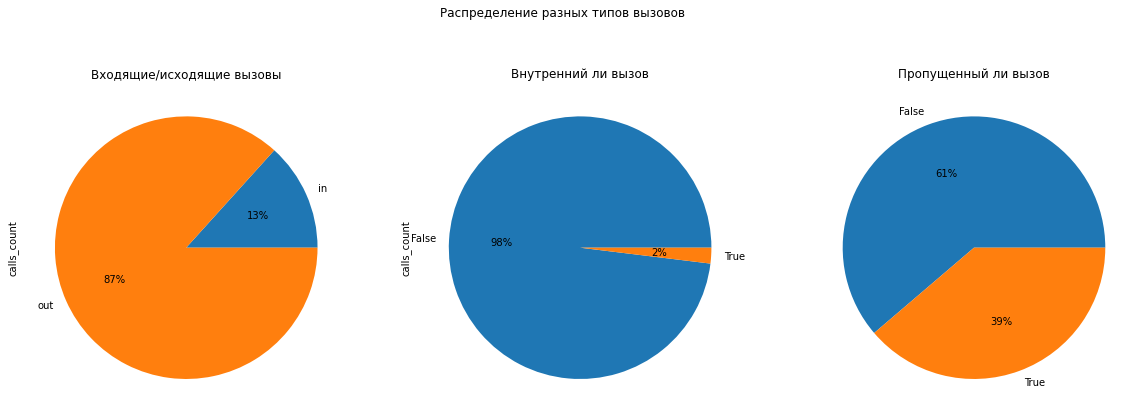

In [130]:
fig,axis = plt.subplots(nrows=1 , ncols=3, figsize=(20, 7))
fig.suptitle('Распределение разных типов вызовов')
axis[0].set_title('Входящие/исходящие вызовы')
df_direction.plot(y='calls_count', kind='pie', legend=False, ax=axis[0], autopct='%1.0f%%') 
axis[1].set_title('Внутренний ли вызов')
df_internal.plot(y='calls_count', kind='pie', legend=False, ax=axis[1], autopct='%1.0f%%')
axis[2].set_title('Пропущенный ли вызов')
df_is_missed_call.plot(y='calls_count', kind='pie', legend=False, ax=axis[2], autopct='%1.0f%%')
plt.ylabel('')  
plt.show()

Построим таблицу с подробным распределением вызовов по типам.

In [131]:
calls_types = data.pivot_table(index={'direction', 'internal', 'is_missed_call'}, values='calls_count', aggfunc='sum').reset_index()
calls_types['percents'] = (calls_types['calls_count'] / calls_types['calls_count'].sum()).round(5)
calls_types.sort_values(by='percents', ascending=False)

,internal,is_missed_call,direction,calls_count,percents
1,False,False,out,328995,0.46892
3,False,True,out,266374,0.37966
0,False,False,in,92150,0.13134
5,True,False,out,7955,0.01134
7,True,True,out,4940,0.00704
4,True,False,in,667,0.00095
2,False,True,in,519,0.00074
6,True,True,in,8,0.00001


Видим, что большую часть вызовов стоставляют внешние исходящие вызовы (47% пропущенных и 38% принятых), 13% это входящие внешние принятые, остальных вызовов совсем мало, на их долю приходится 2%.

### Количественные переменные

Сразу добавим столбцы, которые понадобятся для дальнейшего анализа: средняя продолжительность разговора и среднее время ожидания ответа.

In [132]:
data['avg_call_duration'] = data['call_duration'] / data['calls_count'] 

In [133]:
data['avg_waiting'] = ((data['total_call_duration'] - data['call_duration']) / data['calls_count']).round(1)
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_call_duration,avg_waiting
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,0.0,1.7
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,0.0,1.0
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,10.0,8.0
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,0.0,8.3
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,1.5,13.0


In [134]:
data[['calls_count', 'call_duration', 'total_call_duration', 'avg_call_duration', 'avg_waiting']].describe()

,calls_count,call_duration,total_call_duration,avg_call_duration,avg_waiting
count,41196.000000,41196.000000,41196.000000,41196.000000,41196.000000
mean,17.030974,1017.604525,1331.880352,77.535340,16.541213
std,59.985700,4080.421104,4804.942098,130.990052,11.924056
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,68.000000,0.000000,8.500000
50%,4.000000,108.000000,293.000000,43.104575,14.700000
75%,14.000000,784.000000,1118.000000,102.000000,21.700000
max,4817.000000,144395.000000,166155.000000,3550.000000,451.200000


Уже из общей таблицы видно, что есть аномалии. Рассмотрим показатели отдельно.

#### Общая длительность вызовов в сутки

Рассмотрим суммарное количество продолжительности вызовов в сутки для каждого оператора. Соберем данные в одну таблицу:

In [135]:
day_total_duration = data.pivot_table(index=['operator_id', 'date'], values='total_call_duration', aggfunc='sum') \
     .sort_values(by='total_call_duration').reset_index()
day_total_duration

,operator_id,date,total_call_duration
0,953460.0,2019-11-28,0
1,900180.0,2019-10-05,0
2,933996.0,2019-11-06,0
3,888868.0,2019-09-01,0
4,906392.0,2019-10-21,0
...,...,...,...
19631,885876.0,2019-10-02,155402
19632,885876.0,2019-09-18,159178
19633,885876.0,2019-09-09,160814
19634,885876.0,2019-09-26,172165


Построим боксплот для распределения:

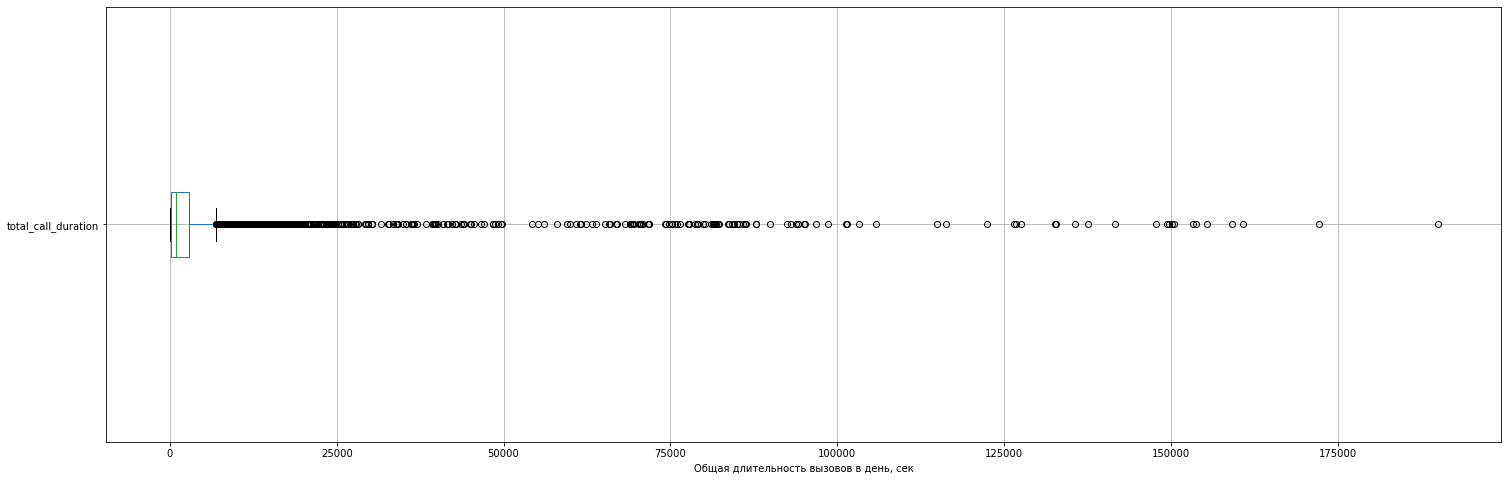

In [143]:
pd.plotting.boxplot(data=day_total_duration, column='total_call_duration', figsize=(25, 8), vert=False)
plt.xlabel('Общая длительность вызовов в день, сек')
plt.show()

По графику видно, что очень много выбросов. Предположим, что максимальный рабочий день оператора -- 12 часов. Согласно стандартам СОРС, оптимальная загрузка оператора 68-76% рабочего времени. Пару часов в день пиковая загрузка может достигать 80-90%, а потом упасть до 60%. Однако средняя за день 68-76%, это оптимальный показатель. Если больше -- считается, что оператор слишком сильно может устать и качество его работы значительно падает. Возьмем максимальную границу нормы 76% и найдем операторо-дни, продолжительность разговора который выше этой границы (в секундах).

In [136]:
too_long_calls = day_total_duration.query('total_call_duration > 12*60*60*0.76')
too_long_calls.head()

,operator_id,date,total_call_duration
19485,929426.0,2019-11-25,33465
19486,885876.0,2019-10-29,33812
19487,885890.0,2019-08-17,33968
19488,885876.0,2019-09-14,34224
19489,908640.0,2019-10-11,34974


In [137]:
too_long_calls.shape[0]

151

151 операторо-дня выше нашей нормы по продолжительности вызовов в день. Удалим соответствующие строки из data. 
Создадим списки операторов и дат, в которые произошли "выбросы". Пройдемся циклом по data, сравним строки с нашими списками и удалим совпадающие.

In [138]:
too_long_date = too_long_calls['date'].tolist() 
too_long_operators = too_long_calls['operator_id'].tolist() 

In [139]:
for x,y in zip(data.operator_id, data.date):
    if (x in too_long_operators and y in too_long_date):
        data = data.drop(data[(data['operator_id'] == x) & (data['date'] == y)].index)

Проверим, все ли удадилось. 

In [140]:
data.pivot_table(index=['operator_id', 'date'], values='total_call_duration', aggfunc='sum') \
     .sort_values(by='total_call_duration').reset_index().query('total_call_duration > 12*60*60*0.76')

,operator_id,date,total_call_duration


Посмотрим еще раз на график, но уже с удаленными аномалиями:

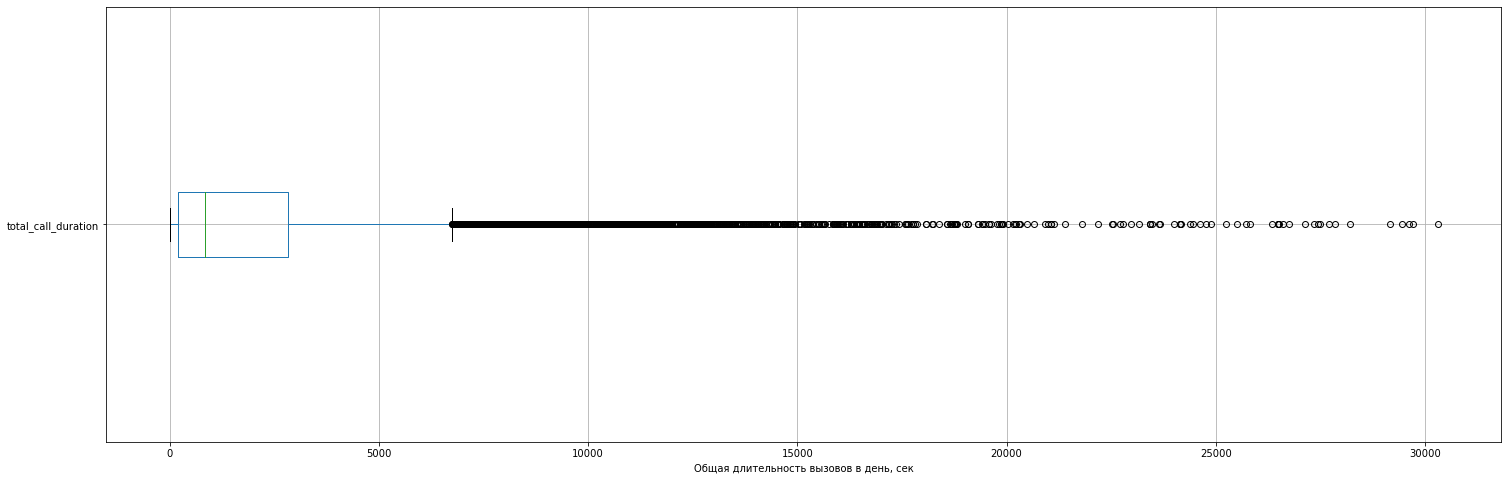

In [142]:
day_total_duration_2 = data.pivot_table(index=['operator_id', 'date'], values='total_call_duration', aggfunc='sum') \
     .sort_values(by='total_call_duration').reset_index()

pd.plotting.boxplot(data=day_total_duration_2, column='total_call_duration', figsize=(25, 8), vert=False)
plt.xlabel('Общая длительность вызовов в день, сек')
plt.show()

#### Количество звонков в день

Рассмотрим суммарное количество всех вызовов на одного оператора в день, за исключением входящих пропущенных (их по сути может быть хоть сколько, на время работы оператора это не влияет). Соберем таблицу:

In [42]:
day_total_calls = data.query('(is_missed_call == False and direction == "in") or direction == "out"').pivot_table(index=['operator_id', 'date'], values='calls_count', aggfunc='sum') \
     .sort_values(by='calls_count').reset_index()
day_total_calls

,operator_id,date,calls_count
0,914036.0,2019-09-18,1
1,900458.0,2019-08-30,1
2,896382.0,2019-09-10,1
3,891160.0,2019-09-20,1
4,891160.0,2019-09-24,1
...,...,...,...
19340,929426.0,2019-11-28,779
19341,929426.0,2019-11-21,833
19342,929428.0,2019-11-08,926
19343,929428.0,2019-11-06,1215


Построим боксплот распределения количества вызовов на одного оператора в сутки.

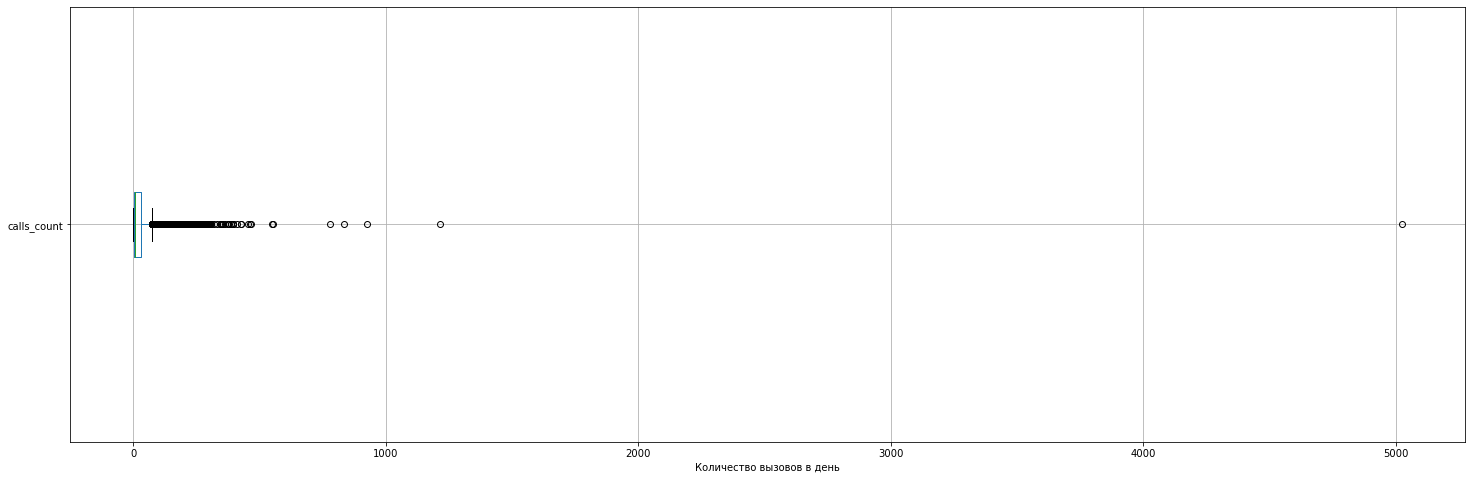

In [43]:
pd.plotting.boxplot(data=day_total_calls, column='calls_count', figsize=(25, 8), vert=False)
plt.xlabel('Количество вызовов в день')
plt.show()

Видим единичные выбросы. Посмотрим, сколько получается звонков в час.

In [44]:
day_total_calls['hour_calls'] = (day_total_calls['calls_count'] / 12).round(1)
day_total_calls

,operator_id,date,calls_count,hour_calls
0,914036.0,2019-09-18,1,0.1
1,900458.0,2019-08-30,1,0.1
2,896382.0,2019-09-10,1,0.1
3,891160.0,2019-09-20,1,0.1
4,891160.0,2019-09-24,1,0.1
...,...,...,...,...
19340,929426.0,2019-11-28,779,64.9
19341,929426.0,2019-11-21,833,69.4
19342,929428.0,2019-11-08,926,77.2
19343,929428.0,2019-11-06,1215,101.2


101 вызов в час совершить еще реально, а вот 418 это уже довольно много, рассмотрим подробнее эти вызовы.

In [144]:
data.query('date == "2019-11-11" and operator_id == 929428.0')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_call_duration,avg_waiting
40731,167827,2019-11-11,out,False,929428.0,False,205,9320,13171,45.463415,18.8
40733,167827,2019-11-11,out,False,929428.0,True,4817,0,5529,0.000000,1.1


In [149]:
data.query('date == "2019-11-11" and operator_id == 929428.0').query('is_missed_call == True')['calls_count'] / 12 / 60

40733    6.690278
Name: calls_count, dtype: float64

Большая часть вызовов этого оператора в этот день -- исходящие пропущенные. Сделав расчет, видим, что почти по 7 вызовов в минуту совершить вполне реально, если на эти вызовы никто не отвечал. Оставим эти данные, они реальны.

#### Среднее время ожидания ответа

Рассмотрим среднее время ожидания входящего вызова по каждому оператору. Время ожидания исходящих вызовов нас не интересует -- оно мало зависит от мастерства оператора.

In [47]:
avg_wait = data.query('direction == "in"').groupby('operator_id')['avg_waiting'].mean().round().sort_values().reset_index()
avg_wait

,operator_id,avg_waiting
0,946582.0,1.0
1,940430.0,1.0
2,890618.0,1.0
3,896020.0,1.0
4,929424.0,1.0
...,...,...
748,920930.0,62.0
749,960296.0,63.0
750,907174.0,65.0
751,917680.0,100.0


Построим гистограмму.

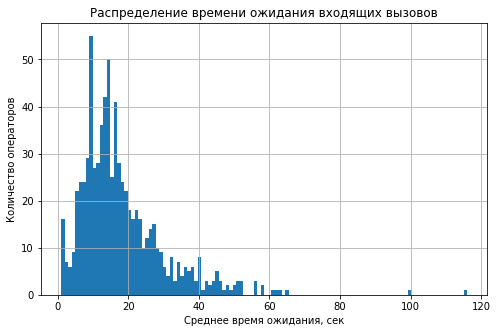

In [152]:
avg_wait.avg_waiting.hist(bins=116, figsize=(8,5)).set_title('Распределение времени ожидания входящих вызовов') 
plt.xlabel('Среднее время ожидания, сек')
plt.ylabel('Количество операторов')
plt.show()

Максимальное среднее время ожидания вызовов -- 116 секунд. Но большая часть вызовов поступает в работу в среднем до 30 секунд.

#### Пропущенные вызовы

Рассмотрим процент пропущенных вызовов исходящих и входящих звонков отдельно, потому как оператор никак не может повлиять на факт пропуска исходящего вызова. Построим таблицу, где для каждого оператора будет указан процент пропущенных входящих звонков.

In [153]:
df_missed_in = data.query('direction == "in"') \
               .pivot_table(index='operator_id', columns='is_missed_call', values='calls_count', aggfunc='sum').reset_index()
df_missed_in.fillna(0, inplace=True)
df_missed_in.columns = ['operator_id', 'not_missed_calls', 'missed_calls']
df_missed_in['total_calls'] = df_missed_in['not_missed_calls'] + df_missed_in['missed_calls']
df_missed_in['part_missed_calls'] = (df_missed_in['missed_calls'] / df_missed_in['total_calls'] * 100).round(1)
df_missed_in = df_missed_in.sort_values(by='part_missed_calls')
df_missed_in

,operator_id,not_missed_calls,missed_calls,total_calls,part_missed_calls
0,879896.0,58.0,0.0,58.0,0.0
476,934608.0,9.0,0.0,9.0,0.0
477,935216.0,2.0,0.0,2.0,0.0
478,935244.0,2.0,0.0,2.0,0.0
479,935264.0,4.0,0.0,4.0,0.0
...,...,...,...,...,...
383,924936.0,6.0,2.0,8.0,25.0
109,897872.0,2.0,1.0,3.0,33.3
467,934098.0,4.0,2.0,6.0,33.3
497,937432.0,2.0,1.0,3.0,33.3


Аналогично для входящих звонков.

In [155]:
df_missed_out = data.query('direction == "out"') \
               .pivot_table(index='operator_id', columns='is_missed_call', values='calls_count', aggfunc='sum').reset_index()
df_missed_out.fillna(0, inplace=True)
df_missed_out.columns = ['operator_id', 'not_missed_calls', 'missed_calls']
df_missed_out['total_calls'] = df_missed_out['not_missed_calls'] + df_missed_out['missed_calls']
df_missed_out['part_missed_calls'] = (df_missed_out['missed_calls'] / df_missed_out['total_calls'] * 100).round(1)
df_missed_out = df_missed_out.sort_values(by='part_missed_calls')
df_missed_out

,operator_id,not_missed_calls,missed_calls,total_calls,part_missed_calls
774,952968.0,1.0,0.0,1.0,0.0
829,960666.0,1.0,0.0,1.0,0.0
121,897894.0,19.0,0.0,19.0,0.0
483,930692.0,6.0,0.0,6.0,0.0
652,941816.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...
680,945074.0,0.0,3.0,3.0,100.0
256,908834.0,0.0,1.0,1.0,100.0
94,894224.0,0.0,33.0,33.0,100.0
839,962904.0,0.0,2.0,2.0,100.0


Построим гистрограммы распределения процентов пропущенных входящих и исходящих вызовов по операторам.

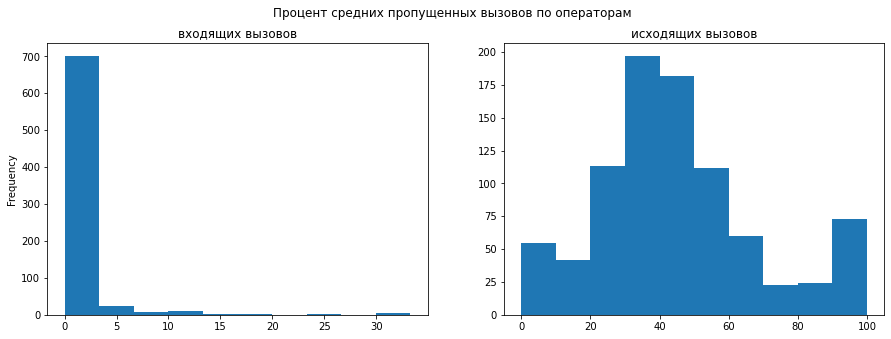

In [156]:
fig,axis = plt.subplots(nrows=1 , ncols=2, figsize=(15, 5))
fig.suptitle('Процент средних пропущенных вызовов по операторам')
axis[0].set_title('входящих вызовов')
df_missed_in.plot(y='part_missed_calls', kind='hist', legend=False, ax=axis[0])
axis[1].set_title('исходящих вызовов')
df_missed_out.plot(y='part_missed_calls', kind='hist', legend=False, ax=axis[1])
plt.ylabel('')
plt.show()

Большая разница в долях пропущенных исходящих и входящих вызовов. Это можно объяснить тем, что при входящих вызовах колл-центр и оператор заинтересован ответить быстрее. А в исходящих вызовах оператор никак не может повлиять, ответит абонент или нет. Отсюда такой большой процент исходящих непринятых звонков.

## Этап 4. Определение неэффективных операторов

Для оценки некоторых критериев будем опираться на отраслевые стандарты СОРС (Customer Operations Performance Center) -- стандарт, разработанный в 1966 году группой компаний Microsoft, Intel, American Express, Dell, Motorola, Novell, это набор минимальных операционных требований к управлению производительностью. Наример:
    
- уровень сервиса (SL/Service Level) -- 80% всех входящих звонков должны быть приняты в течение 20 секунд (ключевой показатель уровня сервиса входящей линии),
- пропущенные звонки (AR/Abandonment Rate, Aban Rate, Lost Call Rate) <= 5% (ключевой показатель уровня сервиса входящей линии).
                                                                          
Эти два показателя являются ключевыми для оценки работы операторов по входящим вызовам. По-хорошему, оператор доложен соответствовать обоим этим условиям. Однако, наши данные могут быть такими, что большая часть операторов не подойдет этим критериям, тогда будем корректировать требования. Третий критерий для операторов на входящих вызовах (процент переадресаций на другого оператора) я бы сделала дополнительным. Наример, признать оператора неэффективным, если он не подходит под один из ключевых критериев плюс дополнительный.
                                                                          
Для оценки работы операторов на исходящих вызовах довольно много критериев, которые мы не можем оценить. Например, конвертация (абоненты, которые согласились выслушать предложение, и абоненты, которые после согласия действительно пришли взять кредит, например), количество продаж в час и другие. У нас нет этих данных, а из того, что есть, разумнее будет оценивать операторов исходящих вызовов по длительности разговора (Average Handle Time/AHT), потому что практика показывает, что чем длиннее разговор, тем вероятнее клиент согласится купить услугу. Попробуем назвать успешными разговоры длиннее 30 секунд. Наверное, быстрее сложно что-то сделать, хотя мы не знаем специализацию операторов (может быть, это соц-опросы на 10 минут?)
Пусть оператор считается эффективным, если хотя бы половина его звонков считаются успешными. 

### Категоризация операторов

Входящие и исходящие вызовы имеют разные показатели качества. Поэтому для оценки эффективности работы операторов необходимо присвоить ему "специализацию" -- на входящих или исходящих вызовых он чаще работает. Построим таблицу с информацией о проценте исходящих вызовов каждого оператора. На основании Этого присвоим операторам категории: оператор входящих вызовов или исходящих.

In [180]:
operator_types = data.query('internal == False').pivot_table(index='operator_id', columns='direction', values='calls_count', aggfunc='sum').reset_index()
operator_types.columns = ['operator_id', 'in_calls', 'out_calls']
operator_types.fillna(0, inplace=True)
operator_types['part_out_calls'] = (operator_types['out_calls'] / (operator_types['out_calls'] + operator_types['in_calls']) * 100).round(1)
operator_types.head()

,operator_id,in_calls,out_calls,part_out_calls
0,879896.0,58.0,816.0,93.4
1,879898.0,103.0,7191.0,98.6
2,880020.0,7.0,34.0,82.9
3,880022.0,8.0,174.0,95.6
4,880026.0,24.0,2188.0,98.9


Допустим, оператор специализируется на исходящих вызовах, если половина или больше его вызовов -- исходящие. Напишем функцию для присвоения операторам категории.

In [181]:
def direction_operator(x):
    if x['part_out_calls'] >= 50:
        return 'out'
    else: 
        return 'in'

In [182]:
operator_types['type'] = operator_types.apply(direction_operator, axis=1)
operator_types.head()

,operator_id,in_calls,out_calls,part_out_calls,type
0,879896.0,58.0,816.0,93.4,out
1,879898.0,103.0,7191.0,98.6,out
2,880020.0,7.0,34.0,82.9,out
3,880022.0,8.0,174.0,95.6,out
4,880026.0,24.0,2188.0,98.9,out


Посмотрим, как рапределились операторы по категориям.

In [183]:
operator_types['type'].value_counts()

out    680
in     374
Name: type, dtype: int64

Операторов исходящих вызовов получилось почти в два раза больше, чем входящих.
Добавим столбец с типом оператора в первоначальный датасет.

In [184]:
data = data.merge(operator_types[['operator_id', 'type']], on = 'operator_id')
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_call_duration,avg_waiting,type_x,type_y,type
0,166377,2019-08-05,out,True,880022.0,True,3,0,5,0.0,1.7,out,out,out
1,166377,2019-08-05,out,False,880022.0,True,3,0,25,0.0,8.3,out,out,out
2,166377,2019-08-08,out,False,880022.0,False,2,558,568,279.0,5.0,out,out,out
3,166377,2019-08-08,out,False,880022.0,True,4,0,28,0.0,7.0,out,out,out
4,166377,2019-08-09,out,False,880022.0,True,2,0,10,0.0,5.0,out,out,out


### Операторы входящих вызовов

Выявим неэффективных операторов, специализирующихся на исходящих вызовах.

In [228]:
in_data = data.query('type == "in"') # выделим "входящих" операторов
in_data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_call_duration,avg_waiting,type_x,type_y,type,week_day
482,166391,2019-08-06,in,False,882476.0,False,1,175,186,175.0,11.0,in,in,in,1
483,166391,2019-09-23,in,False,882476.0,False,1,4,24,4.0,20.0,in,in,in,0
484,166391,2019-11-22,in,False,882476.0,False,1,13,77,13.0,64.0,in,in,in,4
485,166391,2019-08-07,in,True,882478.0,False,2,11,74,5.5,31.5,in,in,in,2
486,166391,2019-08-07,in,False,882478.0,False,1,57,70,57.0,13.0,in,in,in,2


#### Уровень сервиса (SL/Service Level) -- 80% всех входящих звонков должны быть приняты в течение 20 секунд 

Первый критерий оценки операторов входящих вызовов это уровень сервиса. Согласно стандартам СОРС, 80% всех входящих вызовов должны быть приняты в течение 20 секунд. Вычислим этот показатель по каждому оператору.

Общее количество входящих вызовов по каждому оператору.

In [227]:
df1 = in_data.query('direction == "in"').pivot_table(index='operator_id', values='calls_count', aggfunc='sum').reset_index()
df1.head()

,operator_id,calls_count
0,882476.0,3
1,882478.0,3
2,882680.0,99
3,884294.0,1
4,884408.0,32


Общее количество входящих вызовов по каждому оператору, среднее ожидание которых не более 20 секунд.

In [226]:
df2 = in_data.query('direction == "in" and avg_waiting <= 20').pivot_table(index='operator_id', values='calls_count', aggfunc='sum').reset_index()
df2.columns = ['operator_id', 'calls_count_wait_less20']
df2.head()

,operator_id,calls_count_wait_less20
0,882476.0,2
1,882478.0,1
2,882680.0,75
3,884294.0,1
4,884408.0,5


Соединяем полученные таблицы и вычисляем процент вызовов, которые были приняты в течение 20 секунд.

In [188]:
sl_operators = pd.merge(df1, df2, how='left') 
sl_operators.fillna(0, inplace=True)
sl_operators['sl'] =(sl_operators['calls_count_wait_less20']/sl_operators['calls_count']*100).round()
sl_operators

,operator_id,calls_count,calls_count_wait_less20,sl
0,882476.0,3,2.0,67.0
1,882478.0,3,1.0,33.0
2,882680.0,99,75.0,76.0
3,884294.0,1,1.0,100.0
4,884408.0,32,5.0,16.0
...,...,...,...,...
369,970244.0,2,0.0,0.0
370,971100.0,3,3.0,100.0
371,971102.0,76,76.0,100.0
372,971354.0,6,6.0,100.0


Количество операторов, у которых этот процент меньше 80.

In [189]:
not_efficient_operators_sl = sl_operators.query('sl < 80')['operator_id']
not_efficient_operators_sl.count()

164

164 оператора не успевают принять 80% входящих вызовов в течение 20 секунд

In [190]:
(not_efficient_operators_sl.count() / in_data['operator_id'].nunique()).round(2)

0.44

44% операторов входящих вызовов являются неэффективными по первому критерию.

#### Пропущенные звонки (AR/Abandonment Rate, Aban Rate, Lost Call Rate) <= 5% 

Следующим ключевым показателем оценки работы оператора входящих вызовов является процент пропущенных вызовов. По стандартам СОРС, он не должен превышать 5%.

Выведем общее количество входящих вызовов по каждому оператору.

In [199]:
df1.head()

,operator_id,calls_count
0,882476.0,3
1,882478.0,3
2,882680.0,99
3,884294.0,1
4,884408.0,32


Количество входящих пропущенных звонков по каждому оператору.

In [201]:
df3 = in_data.query('direction == "in" and is_missed_call == True').pivot_table(index='operator_id', values='calls_count', aggfunc='sum').reset_index()
df3.columns = ['operator_id', 'missed_calls_count']
df3.head()

,operator_id,missed_calls_count
0,882680.0,3
1,884408.0,1
2,888406.0,1
3,888532.0,2
4,890582.0,1


In [193]:
ar_operators = pd.merge(df1, df3, how='left') 
# объединяем таблицы
ar_operators.fillna(0, inplace=True)
ar_operators['ar'] =(ar_operators['missed_calls_count']/ar_operators['calls_count']*100).round()
# вычисляем процент пропущенных входящих вызовов
ar_operators.head()

,operator_id,calls_count,missed_calls_count,ar
0,882476.0,3,0.0,0.0
1,882478.0,3,0.0,0.0
2,882680.0,99,3.0,3.0
3,884294.0,1,0.0,0.0
4,884408.0,32,1.0,3.0


Выведем список операторов, у которых процент пропущенных вызовов больше 5.

In [202]:
not_efficient_operators_ar = ar_operators.query('ar > 5')['operator_id']
not_efficient_operators_ar.count()

23

Посчитаем процент таких операторов.

In [196]:
round(not_efficient_operators_ar.count() / in_data['operator_id'].nunique(), 2)

0.06

Всего 6% операторов исходящих вызовов не удовлетворяют второму критерию.

#### Доля переведенных вызовов

Дополнительным критерием оценки работы операторов входящих вызовов хотим рассмотреть процент звонков, переведенных на другого оператора. Это означает, что оператор не смог самостоятельно решить вопрос абонента. Составим соответствующую таблицу.

Выделим все непропущенные звонки по каждому оператору.

In [229]:
redirect_operators1 = data.query('is_missed_call == False').pivot_table(index='operator_id', values='calls_count', aggfunc='sum').reset_index()
redirect_operators1.head()

,operator_id,calls_count
0,879896.0,679
1,879898.0,4952
2,880020.0,23
3,880022.0,92
4,880026.0,1584


Все переадресованные звонки (внутренние + исходящие).

In [230]:
redirect_operators2 = data.query('internal == True and direction == "out"').pivot_table(index='operator_id', values='calls_count', aggfunc='sum').reset_index()
redirect_operators2.columns = ['operator_id', 'redirect_calls_count']
redirect_operators2.head()

,operator_id,redirect_calls_count
0,879896.0,56
1,879898.0,18
2,880020.0,4
3,880022.0,15
4,880026.0,20


Добавим столбец с долей переадресованных звонков.

In [54]:
redirect_operators = pd.merge(redirect_operators1, redirect_operators2, how='left') # соединяем таблицы
redirect_operators.fillna(0, inplace=True)
redirect_operators['part_redirect_calls'] =(redirect_operators['redirect_calls_count']/redirect_operators['calls_count']*100).round(1)
redirect_operators = redirect_operators.sort_values(by='part_redirect_calls')
redirect_operators

,operator_id,calls_count,redirect_calls_count,part_redirect_calls
1056,973286.0,2,0.0,0.0
488,921574.0,835,0.0,0.0
489,921584.0,508,0.0,0.0
490,921592.0,980,0.0,0.0
491,921594.0,581,0.0,0.0
...,...,...,...,...
948,954380.0,1,4.0,400.0
855,947480.0,1,4.0,400.0
636,934476.0,2,10.0,500.0
238,904344.0,1,5.0,500.0


Видим, что есть операторы с процентом переадресованных звонков больше 100... сколько их?

In [55]:
redirect_operators.query('part_redirect_calls > 100').shape[0]

55

Целых 55 операторов с нереальным процентом переведенных вызовов. Такого, конечно, быть не может. С чем это может быть связано? Посмотрим на количество внутренних вызовов входящих и исходящих:

In [56]:
data.query('internal == True').pivot_table(index='direction', values='calls_count', aggfunc='sum')

,calls_count
direction,
in,675
out,12876


Исходящих внутренних вызовов между операторами в несколько раз больше, чем входящих. По идее, их количество должно быть равным. Значит, на такой критерий опираться нельзя. Возможно, это возникло из-за неполноты данных, необходимо передать информацию об этих аномалиях программистам. Возможно, стоит добавить еще одну характеристику звонку -- был ли он переадресован на другого оператора.
Предлагаю выявлять неэффективных операторов входящих вызовов на основании первых двух критериев. Оператор признается неэффективным, если не соответствует хотя бы одному из двух критериев оценки.

Объединяем списки неэффективных операторов по обоим критериям.

In [203]:
not_efficient_operators_in = set(not_efficient_operators_sl) | set(not_efficient_operators_ar)
len(not_efficient_operators_in)

171

Посчитаем процент неэффективных операторов.

In [204]:
len(not_efficient_operators_in) / in_data['operator_id'].nunique() 

0.4572192513368984

Самыми неэффективными назовем операторов, которые не попадают под оба критерия эффективности.

In [75]:
most_not_efficient_operators_in = set(not_efficient_operators_sl) & set(not_efficient_operators_ar)
len(most_not_efficient_operators_in)

16

Выведем список неэффективных операторов.

In [205]:
not_efficient_operators_in

{882476.0,
 882478.0,
 882680.0,
 884408.0,
 886892.0,
 887278.0,
 888406.0,
 888532.0,
 888536.0,
 888540.0,
 891254.0,
 891646.0,
 891900.0,
 891906.0,
 891918.0,
 892530.0,
 892534.0,
 892536.0,
 893172.0,
 893402.0,
 893420.0,
 894120.0,
 894614.0,
 895140.0,
 895782.0,
 895786.0,
 896010.0,
 896018.0,
 896536.0,
 896538.0,
 898558.0,
 898560.0,
 899268.0,
 899892.0,
 899898.0,
 899900.0,
 900194.0,
 901350.0,
 901492.0,
 901498.0,
 901894.0,
 902910.0,
 903390.0,
 903512.0,
 904044.0,
 904372.0,
 905300.0,
 905472.0,
 905478.0,
 905862.0,
 906070.0,
 906076.0,
 906396.0,
 906398.0,
 906408.0,
 906410.0,
 906680.0,
 907502.0,
 907504.0,
 907618.0,
 907952.0,
 907982.0,
 908098.0,
 908130.0,
 908152.0,
 908162.0,
 908300.0,
 908834.0,
 908958.0,
 908960.0,
 909134.0,
 909392.0,
 909624.0,
 909768.0,
 910018.0,
 910516.0,
 910540.0,
 910958.0,
 911102.0,
 911136.0,
 911138.0,
 911140.0,
 911142.0,
 911152.0,
 912010.0,
 912684.0,
 914256.0,
 914440.0,
 914842.0,
 918888.0,
 919214.0,

Посчитаем процент самых неэффективных операторов.

In [206]:
len(most_not_efficient_operators_in) / in_data['operator_id'].nunique()

0.0427807486631016

Выведем список колл-центров, в которых работают неэффективные операторы.

In [207]:
not_efficient_users_in = data.query('operator_id in @not_efficient_operators_in')['user_id'].unique()
not_efficient_users_in

array([166391, 166392, 166407, 166428, 166482, 166485, 166503, 166536,
       166541, 166548, 166604, 166658, 166660, 166669, 166697, 166711,
       166713, 166726, 166732, 166782, 166800, 166803, 166836, 166837,
       166839, 166843, 166879, 166901, 166908, 166916, 166939, 166955,
       166975, 166983, 167003, 167031, 167052, 167059, 167078, 167082,
       167102, 167150, 167158, 167162, 167176, 167188, 167189, 167200,
       167264, 167272, 167286, 167402, 167412, 167436, 167445, 167456,
       167466, 167475, 167487, 167497, 167521, 167534, 167551, 167575,
       167580, 167621, 167664, 167715, 167742, 167792, 167819, 167930,
       167949, 167976, 167977, 167994, 167995, 168004, 168041, 168062,
       168073, 168090, 168091, 168105, 168110, 168121, 168155, 168187,
       168221, 168225, 168252, 168307, 168336, 168366, 168412, 168579],
      dtype=int64)

Список колл-центров, в которых работают самые неэффективные операторы.

In [79]:
most_not_efficient_users_in = data.query('operator_id in @most_not_efficient_operators_in')['user_id'].unique()
most_not_efficient_users_in

array([166407, 166482, 166669, 166782, 166837, 166879, 166975, 167059,
       167162, 167497, 167977, 168004], dtype=int64)

In [80]:
len(not_efficient_users_in)

96

In [81]:
len(most_not_efficient_users_in)

12

Итак, 
- 171 неэффективных операторов (почти 46%) работают в 96 колл-центрах.

Дополнительно: 
- 16 самых неэффективных (4%) операторов работают в 12 колл-центрах.

### Операторы исходящих вызовов

Назовем исходящие разговоры успешными от 30 секунд. Пусть оператор считается эффективным, если хотя бы половина его звонков являются успешными.

Выделяем "исходящих" операторов (только внешние вызовы).

In [209]:
out_data = data.query('type == "out" and internal == False')
out_data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_call_duration,avg_waiting,type_x,type_y,type
1,166377,2019-08-05,out,False,880022.0,True,3,0,25,0.000000,8.3,out,out,out
2,166377,2019-08-08,out,False,880022.0,False,2,558,568,279.000000,5.0,out,out,out
3,166377,2019-08-08,out,False,880022.0,True,4,0,28,0.000000,7.0,out,out,out
4,166377,2019-08-09,out,False,880022.0,True,2,0,10,0.000000,5.0,out,out,out
6,166377,2019-08-26,out,False,880022.0,False,3,1079,1093,359.666667,4.7,out,out,out


Общее количество исходящих звонков по каждому оператору.

In [212]:
df4 = out_data.pivot_table(index='operator_id', values='calls_count', aggfunc='sum').reset_index()
df4.head()

,operator_id,calls_count
0,879896.0,874
1,879898.0,7294
2,880020.0,41
3,880022.0,182
4,880026.0,2212


Общее количество звонков длительностью от 30 секунд по каждому оператору.

In [213]:
df5 = out_data.query('avg_call_duration >= 30').pivot_table(index='operator_id', values='calls_count', aggfunc='sum').reset_index()
df5.columns = ['operator_id', 'more30_calls_count']
df5.head()

,operator_id,more30_calls_count
0,879896.0,634
1,879898.0,4894
2,880020.0,19
3,880022.0,86
4,880026.0,1579


In [214]:
out_operators = pd.merge(df4, df5, how='left') 
# соединяем таблицы
out_operators.fillna(0, inplace=True)
out_operators['part_more30_calls_count'] =(out_operators['more30_calls_count']/out_operators['calls_count']*100).round()
# вычисляем процент успешных звонков
out_operators.head()

,operator_id,calls_count,more30_calls_count,part_more30_calls_count
0,879896.0,874,634.0,73.0
1,879898.0,7294,4894.0,67.0
2,880020.0,41,19.0,46.0
3,880022.0,182,86.0,47.0
4,880026.0,2212,1579.0,71.0


Выведем список операторов, у которых меньше половины успешных звонков (продолжительностью от 30 секунд)

In [86]:
not_efficient_operators_out = out_operators.query('part_more30_calls_count < 50')['operator_id']
not_efficient_operators_out

2      880020.0
3      880022.0
7      881278.0
12     883018.0
18     884478.0
         ...   
670    970252.0
672    970258.0
673    970484.0
678    972460.0
679    973120.0
Name: operator_id, Length: 233, dtype: float64

Количество неэффективных операторов.

In [215]:
not_efficient_operators_out.count()

233

Процент неэффективных операторов исходящих вызовов.

In [218]:
round(not_efficient_operators_out.count() / data.query('type == "out"')['operator_id'].nunique() * 100, 2)

34.26

Cписок колл-центров, в которых работают самые неэффективные операторы.

In [219]:
not_efficient_users_out = data.query('operator_id in @not_efficient_operators_out')['user_id'].unique()
not_efficient_users_out

array([166377, 166405, 166407, 166485, 166507, 166520, 166533, 166536,
       166604, 166609, 166680, 166688, 166692, 166711, 166732, 166774,
       166813, 166839, 166843, 166874, 166939, 166940, 166941, 166971,
       167002, 167011, 167012, 167016, 167060, 167078, 167082, 167109,
       167110, 167112, 167113, 167122, 167125, 167150, 167172, 167175,
       167183, 167185, 167188, 167263, 167275, 167364, 167436, 167451,
       167471, 167479, 167487, 167497, 167530, 167543, 167580, 167626,
       167645, 167646, 167650, 167654, 167727, 167742, 167759, 167805,
       167827, 167852, 167923, 167947, 167955, 167969, 167989, 167994,
       167995, 167999, 168008, 168010, 168018, 168021, 168062, 168073,
       168091, 168093, 168097, 168105, 168121, 168128, 168185, 168187,
       168193, 168221, 168225, 168228, 168252, 168291, 168361, 168412,
       168473, 168481], dtype=int64)

In [90]:
len(not_efficient_users_out)

98

Итак, 233 неэффективных оператора исходящих вызовов (34%) работают в 98 колл-центрах.

## Этап 5. Проверка гипотез

###  О пропущенных исходящих внешних вызовах

Предположим, что процент исходящих внешних пропущенных вызовов в будни и выходные дни не различается.
(Влияет ли рабочий день на то, что человеку некогда ответить?) 

- H0: Средняя доля исходящих пропущенных внешних вызовов в будни и выходные одинакова.
- H1: Средняя доля исходящих пропущенных внешних вызовов в будни и выходные различна.

Добавим столбец с указанием дня недели (0 - понедельник, 1 - вторник и т.д.)

In [220]:
data['week_day'] = data['date']. dt.weekday
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_call_duration,avg_waiting,type_x,type_y,type,week_day
0,166377,2019-08-05,out,True,880022.0,True,3,0,5,0.0,1.7,out,out,out,0
1,166377,2019-08-05,out,False,880022.0,True,3,0,25,0.0,8.3,out,out,out,0
2,166377,2019-08-08,out,False,880022.0,False,2,558,568,279.0,5.0,out,out,out,3
3,166377,2019-08-08,out,False,880022.0,True,4,0,28,0.0,7.0,out,out,out,3
4,166377,2019-08-09,out,False,880022.0,True,2,0,10,0.0,5.0,out,out,out,4


Посчитаем общее количество внешних исходящих вызовов по каждому оператору в каждый день недели.

In [92]:
stat_data_all = data.query('direction == "out" and internal == False') \
    .pivot_table(index=['operator_id', 'week_day'], values='calls_count', aggfunc='sum').reset_index()
stat_data_all.head()

,operator_id,week_day,calls_count
0,879896.0,0,93
1,879896.0,1,70
2,879896.0,2,201
3,879896.0,3,161
4,879896.0,4,254


Посчитаем общее количество пропущенных внешних исходящих вызовов по каждому оператору.

In [93]:
stat_data_missed = data.query('direction == "out" and internal == False and is_missed_call == True') \
    .pivot_table(index=['operator_id', 'week_day'], values='calls_count', aggfunc='sum').reset_index()
stat_data_missed.columns = ['operator_id', 'week_day', 'missed_calls_count']
stat_data_missed.head()

,operator_id,week_day,missed_calls_count
0,879896.0,0,21
1,879896.0,1,12
2,879896.0,2,55
3,879896.0,3,41
4,879896.0,4,73


Объединим таблицы.

In [94]:
stat_data = pd.merge(stat_data_all, stat_data_missed, how='left', on=['operator_id','week_day']) 
stat_data.fillna(0, inplace=True)
stat_data['part_missed_calls'] =(stat_data['missed_calls_count']/stat_data['calls_count']).round(2)
# вычислим долю пропущенных
stat_data.head()

,operator_id,week_day,calls_count,missed_calls_count,part_missed_calls
0,879896.0,0,93,21.0,0.23
1,879896.0,1,70,12.0,0.17
2,879896.0,2,201,55.0,0.27
3,879896.0,3,161,41.0,0.25
4,879896.0,4,254,73.0,0.29


Выделим будни.

In [95]:
missed_calls_weekdays = stat_data.query('week_day in [0, 1, 2, 3, 4]')
missed_calls_weekdays.head()

,operator_id,week_day,calls_count,missed_calls_count,part_missed_calls
0,879896.0,0,93,21.0,0.23
1,879896.0,1,70,12.0,0.17
2,879896.0,2,201,55.0,0.27
3,879896.0,3,161,41.0,0.25
4,879896.0,4,254,73.0,0.29


Выделим выходные.

In [96]:
missed_calls_weekends = stat_data.query('week_day in [5, 6]')
missed_calls_weekends.head()

,operator_id,week_day,calls_count,missed_calls_count,part_missed_calls
5,879896.0,5,34,16.0,0.47
6,879896.0,6,3,2.0,0.67
12,879898.0,5,15,1.0,0.07
13,879898.0,6,1,0.0,0.00
44,882684.0,5,67,21.0,0.31


Построим гистрограммы распределения доли пропущенных исходящих внешних вызовов по операторам в будни и выходные дни.

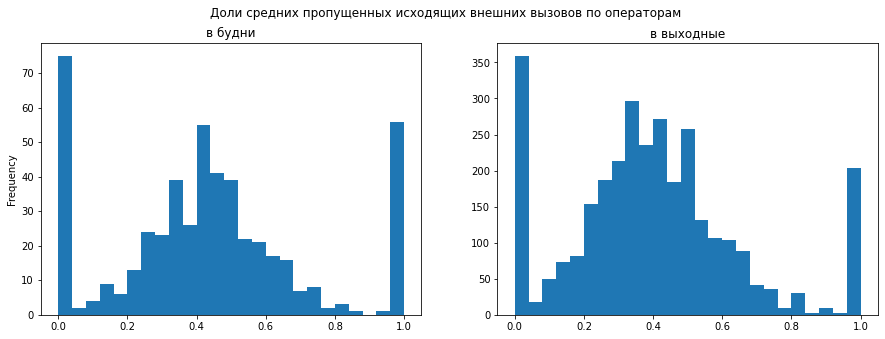

In [221]:
fig,axis = plt.subplots(nrows=1 , ncols=2, figsize=(15, 5))
fig.suptitle('Доли средних пропущенных исходящих внешних вызовов по операторам')
axis[0].set_title('в будни')
missed_calls_weekends.plot(y='part_missed_calls', kind='hist', legend=False, bins=25, ax=axis[0])
axis[1].set_title('в выходные')
missed_calls_weekdays.plot(y='part_missed_calls', kind='hist', legend=False, bins=25, ax=axis[1])
plt.ylabel('')
plt.show()

Графики довольно похожи. Распределения не соответствуют нормальным. В этом случае лучше всего подходит тест Манна‑Уитни.

In [222]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(missed_calls_weekdays['part_missed_calls'], missed_calls_weekends['part_missed_calls'])

print('p-value =', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Считаем средние доли пропущенных исходящих внешних вызовов разными.')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Считаем средние доли пропущенных исходящих внешних вызовов одинаковым') 
print('Средняя доля пропущенных исходящих внешних вызовов в будни:', "{0:.2f}".format(missed_calls_weekdays['part_missed_calls'].mean()))
print('Средняя доля пропущенных исходящих внешних вызовов в выходные:', "{0:.2f}".format(missed_calls_weekends['part_missed_calls'].mean()))
print('Различие в средней доле пропущенных исходящих внешних звонков в выходные к будням =', "{0:.3f}".format(missed_calls_weekends['part_missed_calls'].mean() / missed_calls_weekdays['part_missed_calls'].mean() - 1))

p-value = 0.003
Отвергаем нулевую гипотезу. Считаем средние доли пропущенных исходящих внешних вызовов разными.
Средняя доля пропущенных исходящих внешних вызовов в будни: 0.39
Средняя доля пропущенных исходящих внешних вызовов в выходные: 0.43
Различие в средней доле пропущенных исходящих внешних звонков в выходные к будням = 0.091


P-value = 0.003, что меньше 0.05 и даже меньше 0.01. Средние доли пропущенных внешних исходящих вызовов в будни и выходные различаются. В выходные дни люди отвечают на звонки операторов реже. Возможно, это связано с тем, что в выходные дни люди стараются реже проводить время с телефоном, а в будни приходится по телефону решать рабочие вопросы.

###  О длительности входящих и исходящих вызовов

Предположим, что среднее время исходящих и входящих разговоров не различается (учитываем только принятые внешние вызовы).

- H0: Средняя продолжительность входящих и исходящих вызовов одинакова.
- H1: Средняя продолжительность входящих и исходящих вызовов различна.

Создадим таблицы с внешними непропущенными входящими и исходящими вызовами.

In [223]:
data_avg_calls_in = data.query('internal == False and is_missed_call == False and direction == "in"')
data_avg_calls_out = data.query('internal == False and is_missed_call == False and direction == "out"')

Построим распределение продолжительности непропущенных внешних вызовов.

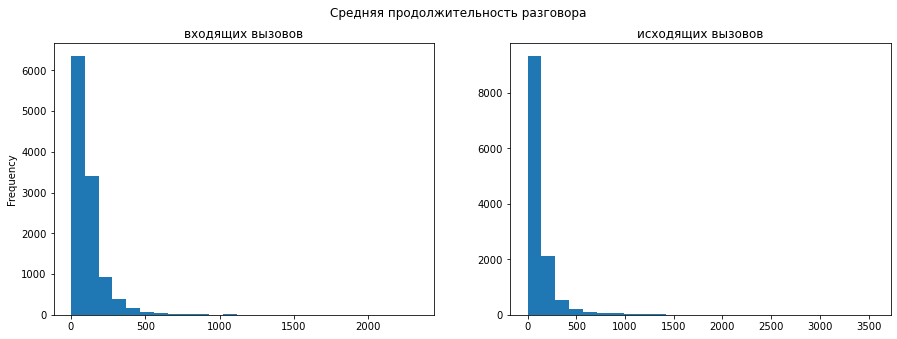

In [224]:
fig,axis = plt.subplots(nrows=1 , ncols=2, figsize=(15, 5))
fig.suptitle('Средняя продолжительность разговора')
axis[0].set_title('входящих вызовов')
data_avg_calls_in.plot(y='avg_call_duration', kind='hist', legend=False, bins=25, ax=axis[0])
axis[1].set_title('исходящих вызовов')
data_avg_calls_out.plot(y='avg_call_duration', kind='hist', legend=False, bins=25, ax=axis[1])
plt.ylabel('')
plt.show()

Графики довольно похожи. Распределения не соответствуют нормальным. В этом случае лучше всего подходит тест Манна‑Уитни.

In [225]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(data_avg_calls_in['avg_call_duration'], data_avg_calls_out['avg_call_duration'])

print('p-value =', "{0:.5f}".format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Считаем среднюю длительность входящих и исходящих вызовов разными.')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Считаем среднюю длительность входящих и исходящих вызовов одинаковым') 
print('Средняя длительность входящего звонка:', "{0:.2f}".format(data_avg_calls_in['avg_call_duration'].mean()))
print('Средняя длительность исходящего звонка:', "{0:.2f}".format(data_avg_calls_out['avg_call_duration'].mean()))
print('Различие в средней продолжительности исходящего вызова к входящему =', "{0:.3f}".format(data_avg_calls_out['avg_call_duration'].mean() / data_avg_calls_in['avg_call_duration'].mean() - 1))

p-value = 0.00010
Отвергаем нулевую гипотезу. Считаем среднюю длительность входящих и исходящих вызовов разными.
Средняя длительность входящего звонка: 114.48
Средняя длительность исходящего звонка: 131.25
Различие в средней продолжительности исходящего вызова к входящему = 0.146


P-value = 0.00010, что меньше 0.05 и даже меньше 0.01. Средние продолжительности входящего и исходящего звонков различаются. Возможно, это связано с тем, что оператору исходящего вызова выгоднее дольше говорить, чтобы убедить клиента купить услугу, например. В то время как задача оператора входящего вызова -- как можно скорее решить вопрос клиента и обработать как можно больше звонков.

## Этап 6. Общий вывод

В процессе предобработки данных были изменены типы данных, выявлены дубликаты и удалены пропуски. Довольно большой процент (15%) операторов отсутствовал, однако замену найти не удалось, а данные без указания оператора не имеют смысла для анализа, такие данные пришлось удалить. Также добавили столбцы с новыми показателями, которые были необходимы для дальнейшей работы. 
Были удалены аномальные данные. Оставшиеся данные были изучены по разным показателям (качественным и количественным), построены графики распредления величин. По результатам анализа показателей были определены следующие критерии эффективной работы операторов. Для операторов входящих вызовов:
- уровень сервиса (SL/Service Level) -- 80% всех входящих звонков должны быть приняты в течение 20 секунд (ключевой показатель уровня сервиса входящей линии),
- пропущенные звонки (AR/Abandonment Rate, Aban Rate, Lost Call Rate) <= 5% (ключевой показатель уровня сервиса входящей линии).

В качестве дополнительного кретерия собирались рассмотреть процент переадресованных другим операторам вызовов, однако в результате анализа получили некорректные данные (процент переадресованных вызовов у довольно большого количества операторов был большее 100%, чего в принципе не может быть). Полагаю, это получилось в результате неполноты данных относительно внутренних вызовов. 

Операторы исходящих вызовов были оценены по продолжительности разговора. Практика показывает, что чем длиннее разговор, тем выше конверсия. Неэффективными посчитали операторов, у которых меньше половины исходящих звонков длительностью до 30 секунд.

По итогу анализы были получены списки неэффективных операторов и списки колл-центров, в которых они работают.
Среди "входящих" операторов были признаны неэффективными 171 оператор (почти 46% от всех "входящих") в 96 колл-центрах.
Дополнительно предложено выделить самых неэффективных 16 операторов (4%  от всех "входящих"), которые не удовлетворяют обоим критериям, они работают в 12 колл-центрах.

Среди "исходящих" операторов 233 (34% от всех "исходящих") оказались неэффективными, они работают в 98 колл-центрах.

При проверке гипотез выяснилось, что средние доли пропущенных внешних исходящих вызовов в будни и выходные различаются. В выходные дни люди отвечают на звонки операторов реже. Также различается средняя продолжительность входящих и исходящих вызовов. Это связано с заинтересованностью оператора.

В результате исследования выявили довольно большой процент неэффективных операторов. Скорее всего, колл-центры заинтересуются новой системой оценки показателей работы операторов.